In [171]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [172]:
df = pd.read_csv('data/tweets_vader.csv', usecols=['Cleaned_Text','Vader_Sentiment_Type'])

In [173]:
df.dropna(inplace=True)

In [174]:
df.shape

(19835, 2)

In [175]:
df['Cleaned_Text'] = df['Cleaned_Text'].str.replace('’',"'")

In [272]:
df.rename(columns={"Vader_Sentiment_Type":"sentiment","Cleaned_Text":"text"}, inplace=True)

def redefine_label(label):
    if label == "NEUTRAL":
        return 0
    elif label == "NEGATIVE":
        return 1
    elif label == "POSITIVE":
        return 2

df["label"] = df["sentiment"].apply(redefine_label)
df.drop(columns=["sentiment"], inplace=True)
df

,text,label
0,it really is not but good to know you will believe any thing someone on the with no founding if it were actually people supporting it our government would actually do something about it but it is old men with money so they get a pass,1
1,indeed i will let us take a teensy fraction of responsibility for some like being some people s first positive imagery of the community the mutual aid-ish and maybe a touch of relationship drama,2
2,actually its not not only have child drag been happening despite with support from the and but they have also taken to people saying that calling out is anti-lgbt somehow they got it in their that those are equal,1
3,government considering repeal of sodomy law along with unspecified to ensure ban on marriage is from court challenge,2
4,on a clear day you can see forever opening night at interesting premise w a clever twist great band nice nostalgic music,2
...,...,...
19995,the movie lit rally like 0 0001 % content ko wo k,2
19996,allies,0
19997,as long as are and clean and not gross then they are fine with me,2
19998,gop-controlled sue over lgbt-inclusive policy to get school lunch funds,0


In [274]:
from sklearn.model_selection import train_test_split
#split the data into train and test set

train,test = train_test_split(df, test_size=0.20, random_state=0)
train,val = train_test_split(train, test_size=0.25, random_state=1)

#save the data
train.to_csv('data/bert_train.csv',index=False)
val.to_csv('data/bert_val.csv',index=False)
test.to_csv('data/bert_test.csv',index=False)

In [178]:
import spacy

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("emoji", first=True)
nlp.pipe_names

['emoji',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [179]:
from tqdm import tqdm

docs = []
for doc in tqdm(nlp.pipe(df.text), total=len(df)):
    docs.append(doc)

100%|██████████| 19835/19835 [00:50<00:00, 393.25it/s]


In [180]:
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_, i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct, i._.is_emoji) for i in doc
    ]

In [181]:
def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct", "is_emoji"
    ]
    
    meta_df = []
    for ix, doc in tqdm(enumerate(docs), total=len(docs)):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df)  

In [182]:
tidy_docs = tidy_tokens(docs)

100%|██████████| 19835/19835 [00:36<00:00, 546.45it/s]


In [183]:
tidy_docs = tidy_docs[tidy_docs.groupby('doc_id').doc_id.transform(len) > 3]

In [184]:
tidy_docs.query("is_emoji == True")

,doc_id,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct,is_emoji
19,5,™,19,™,,VB,dobj,VERB,False,False,False,False,True
24,16,🙄,24,🙄,,NN,dobj,NOUN,False,False,False,False,True
13,19,✅,13,✅,,_SP,dep,SPACE,False,False,False,False,True
0,30,💗,0,💗,,NNP,npadvmod,PROPN,False,False,False,False,True
26,50,😢,26,😢,,FW,punct,X,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,19818,🏳️‍🌈,28,🏳️‍🌈,ORG,_SP,dep,SPACE,False,False,False,False,True
29,19818,🏳️‍🌈,29,🏳️‍🌈,ORG,ADD,dep,X,False,False,False,False,True
30,19818,🏳️‍🌈,30,🏳️‍🌈,ORG,ADD,dep,X,False,False,False,False,True
19,19829,🌈,19,🌈,,RB,dep,ADV,False,False,False,False,True


In [185]:
emoji_list = tidy_docs.query("is_emoji == True").token.unique()
emoji_df = pd.DataFrame({'emoji':emoji_list})

emoji_df.to_csv('emoji.csv')

In [186]:
tidy_docs.query("ent_type != ''").ent_type.value_counts()

DATE           3426
ORG            3291
CARDINAL       3184
PERCENT         840
PERSON          831
GPE             693
ORDINAL         577
TIME            493
NORP            308
MONEY           262
PRODUCT         157
LOC             145
QUANTITY        143
LAW             122
FAC              79
EVENT            31
WORK_OF_ART       7
LANGUAGE          1
Name: ent_type, dtype: int64

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150'),
  Text(200.0, 0, '200'),
  Text(250.0, 0, '250'),
  Text(300.0, 0, '300'),
  Text(350.0, 0, '350'),
  Text(400.0, 0, '400')])

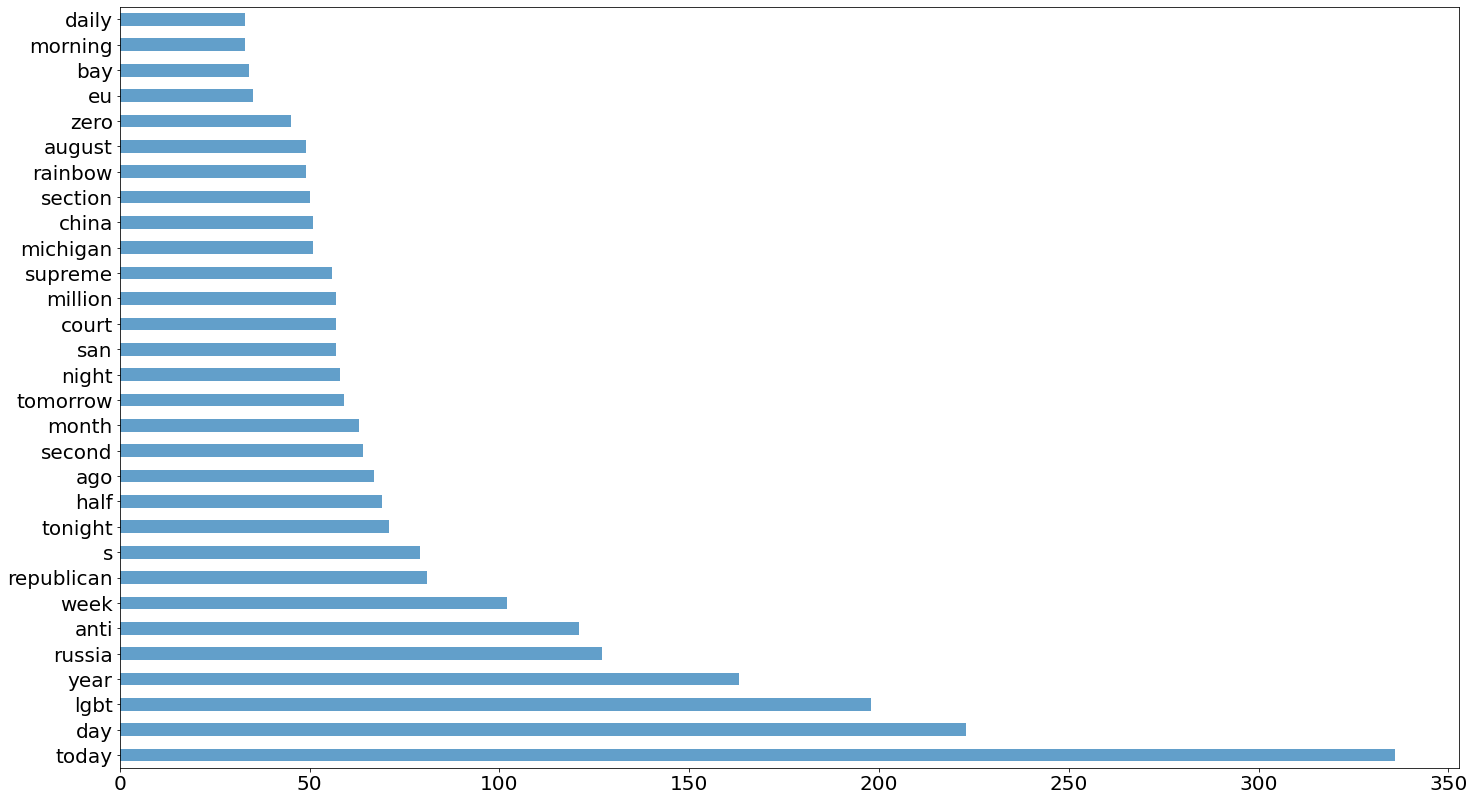

In [267]:
import matplotlib.pyplot as plt 

tidy_docs.query("ent_type != '' & pos != 'SPACE' & is_stop == False & \
is_punct == False & is_emoji == False & is_digit == False & is_alpha == True").lemma.value_counts().head(30).plot(kind="barh", figsize=(24, 14), alpha=.7)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [214]:
alphanumeric_list = tidy_docs.query("ent_type != '' & pos != 'SPACE' & is_stop == False & \
is_punct == False & is_emoji == False & is_digit == False").lemma.unique()
alpha_list = tidy_docs.query("ent_type != '' & pos != 'SPACE' & is_stop == False & \
is_punct == False & is_emoji == False & is_digit == False & is_alpha == True").lemma.unique()


In [215]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [216]:
alphanumeric_list = set(alphanumeric_list) - set(tokenizer.vocab.keys())
alpha_list = set(alpha_list) - set(tokenizer.vocab.keys())

In [224]:
import enchant

d = enchant.Dict("en_US")

english_words = set()

for new_token in sorted(alphanumeric_list):
    if d.check(new_token) == True:
        english_words.add(new_token)

In [225]:
print(sorted(alphanumeric_list-english_words-alpha_list))

['-4pm', '00am', '00pmemail', '00s', '100k', '100x', '10but', '10even', '10my', '10pm', '10yo', '10yr', '110k', '11am', '11am-4pm', '11k', '11yr', '12noon', '13statehood', '14bl', '14x14', '14yo', '15y', '167m', '16x16', '1850s-1950s', '1927leo', '19a', '1k', '1kick', '1not', '1pm-5pm', '1yr', '200k', '2015has', '2019nas', '2020s', '2020we', '2022a', '2022i', '2022you', '2030you', '20k', '20x20', '220k', '22k', '22yr', '24h', '24mil', '24winter', '24x7', '25k', '25x', '25yr', '26am', '26pm', '273–280', '28july22', '2b', '2by', '2ds', '2hosted', '2investigate', '2k', '2lgbtqias', '2nite', '2pm-2am', '2rd', '2slgbtq', '2thessalonians', '2yr', '30am', '30k', '30pm', '317k', '377a', '3chuds', '3dp', '3go', '3i', '3k', '3rs', '3source', '3x', '3yrs', '40ish', '40k', '40s', '470k', '4chan', '4gotten', '4lye', '4or', '4pmpst', '500k', '50a', '50p', '50x', '5k', '5lazytime', '5mil', '5pmmore', '5tags', '5tips', '5towards', '5yo', '5yr', '65mcmlxv', '66k', '680k', '6p-2a', '6pm-12pm', '6r00mer'

In [264]:
vocab_list = sorted(alpha_list-english_words)
words_to_add = ['2nite','2lgbtqias','bagus','covid-19','fair1','furrie','gta','inb4','ppls','proship','proshpped0','rated18','sama','su1c1de','l3sbians','lgbt2','lgbtabc123xyz','lgbtq2','lgbtqia2','lgbt÷','ww2']
for word in words_to_add:
    vocab_list.append(word)
print(sorted(vocab_list))

['2lgbtqias', '2nite', 'abbasi', 'ade', 'aku', 'atonia', 'awwww', 'bagus', 'benda', 'biden', 'bradbury', 'cee', 'chakra', 'charle', 'cosa', 'covid-19', 'cupcakke', 'elysia', 'etcnon', 'fair1', 'familia', 'fil', 'furrie', 'gc', 'georgiafreedom', 'goldwater', 'gop', 'grat', 'grt', 'gta', 'hak', 'ig', 'inb4', 'kadhi', 'kalo', 'karlsberg', 'koda', 'kulah', 'l3sbians', 'latifi', 'lgbt2', 'lgbtabc123xyz', 'lgbtq', 'lgbtq2', 'lgbtqia2', 'lgbt÷', 'looney', 'mau', 'nep', 'peele', 'ppls', 'proship', 'proshpped0', 'rated18', 'rogan', 'rostow', 'rp', 'sama', 'su1c1de', 'tabeta', 'titanbi', 'vag', 'vinny', 'visto', 'wickham', 'ww2', 'yagi', 'zahra', '新人vtuber']


In [275]:
non_english_list_df = pd.DataFrame({'word':sorted(vocab_list)})

non_english_list_df.to_csv('vocab.csv')